In [1]:
import glam
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt

/Users/pradyumna/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/pradyumna/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import pymc3 as pm

In [3]:
np.random.seed(23) # from random.org

# Individual GLAM estimation and out of sample prediction (Dislike Inv)

##  Load data

In [4]:
# Load data
sufix = '_individual_Dislike_Inv_NoBin_Gamma-11_NUTS_31'
data = pd.read_csv('data/FF2018_data/GlamDataFF2018_Dislike_NoBin_Inv_31.csv')

# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,0,0,1,3327,2.05,1.00,0.745415,0.254585
1,0,1,1,3424,0.70,1.30,0.410720,0.589280
2,0,2,1,3691,1.30,1.75,0.330549,0.669451
3,0,3,0,8144,1.45,0.70,0.592345,0.407655
4,0,4,0,6559,1.00,1.00,0.641717,0.358283


## Split data in training and test sets

In [5]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

test_data.to_csv(str('data/FF2018_data/GlamDataFF2019_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/FF2018_data/GlamDataFF2019_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1860 trials) and test (1860 trials) sets...


In [6]:
train_data

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,0,0,1,3327,2.05,1.00,0.745415,0.254585
2,0,2,1,3691,1.30,1.75,0.330549,0.669451
4,0,4,0,6559,1.00,1.00,0.641717,0.358283
6,0,6,1,2470,1.45,1.90,0.329730,0.670270
8,0,8,1,4669,1.45,1.30,0.419431,0.580569
10,0,10,0,3301,1.90,1.90,0.605079,0.394921
12,0,12,1,3117,1.15,1.90,0.506602,0.493398
14,0,14,0,2754,1.75,1.45,0.596632,0.403368
16,0,16,1,3931,1.15,1.30,0.338392,0.661608
18,0,18,0,5674,1.30,1.60,0.410655,0.589345


## Individual GLAM estimation

### 1. full GLAM

In [7]:
# Fitting full GLAM
print('Fitting full GLAM individually...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2019_full'+sufix+'.npy')):
    glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_FF2019_full'+sufix+'.npy'))   

Fitting full GLAM individually...
Generating single subject models for 31 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 31 model(s) using NUTS...
  Fitting model 1 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [06:29<00:00,  7.95draws/s]
The acceptance probability does not match the target. It is 0.9999073525201414, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 2 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [11:44<00:00,  4.34draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 3 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1171.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 4 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1240.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 5 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1310.63draws/s]
The acceptance probability does not match the target. It is 0.8868660670392166, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 6 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:48<00:00, 355.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 7 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:26<00:00, 139.09draws/s]
The acceptance probability does not match the target. It is 0.8833081765734325, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9134330046147555, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 8 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1453.71draws/s]
The acceptance probability does not match the target. It is 0.8805841356034072, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868223105033459, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 9 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:32<00:00, 78.55draws/s] 
The acceptance probability does not match the target. It is 0.9824519069007104, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 10 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:07<00:00, 1577.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 11 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:20<00:00, 149.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 12 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 902.80draws/s]
The acceptance probability does not match the target. It is 0.6844141796154958, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 13 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [11:44<00:00,  4.41draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.99986127971699, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 14 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:07<00:00, 1510.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 15 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1249.31draws/s]
The acceptance probability does not match the target. It is 0.7190710072846623, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 16 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [11:36<00:00,  4.26draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.899157140365335, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 17 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1254.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 18 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1390.60draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 19 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1111.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 20 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1394.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 21 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1216.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 22 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 920.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 23 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 869.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 24 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1248.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 25 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1357.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 26 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1140.69draws/s]
The acceptance probability does not match the target. It is 0.6952554214189325, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6630321520985702, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 27 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1075.14draws/s]
The acceptance probability does not match the target. It is 0.8896579920721721, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 28 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:15<00:00, 796.32draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 29 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:01<00:00, 196.17draws/s]
The acceptance probability does not match the target. It is 0.9008008576196882, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 30 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1184.94draws/s]
The acceptance probability does not match the target. It is 0.8852824957873198, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 31 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:32<00:00, 134.69draws/s]
The acceptance probability does not match the target. It is 0.9795509342316376, but should be close to 0.8. Try to increase the number of tuning steps.


/!\ Automatically setting parameter precision...


In [8]:
# Save parameter estimates
np.save(str('results/estimates/glam_FF2019_full'+sufix+'.npy'), glam_full.estimates)
pd.DataFrame(glam_full.estimates)

,SNR,b,gamma,p_error,s,t0,tau,v
0,180.28,1.0,0.62,0.05,0.006407,[0.0],3.56,0.000037
1,37.53,1.0,0.43,0.05,0.004241,[0.0],0.45,0.000049
2,146.71,1.0,0.99,0.05,0.007717,[0.0],0.80,0.000044
3,183.63,1.0,0.16,0.05,0.007155,[0.0],3.00,0.000036
4,214.51,1.0,0.36,0.05,0.009292,[0.0],4.92,0.000048
5,210.12,1.0,0.29,0.05,0.008504,[0.0],4.76,0.000045
6,132.99,1.0,0.27,0.05,0.008919,[0.0],1.27,0.000063
7,139.13,1.0,-0.06,0.05,0.006858,[0.0],4.19,0.000042
8,167.29,1.0,-0.98,0.05,0.008069,[0.0],2.58,0.000047
9,122.06,1.0,-0.69,0.05,0.006391,[0.0],4.85,0.000052


In [11]:
full_params = pd.DataFrame(glam_full.estimates)
full_params.to_csv(str('results/params_estimates/params_glam_FF2019_full'+sufix+'.csv'))

In [12]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_FF2019_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full.waic = np.load(str('results/waic/glam_FF2019_full'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_FF2019_full'+ sufix +'.npy'), glam_full.waic)

In [16]:
waic_values = pd.DataFrame(glam_full.waic)
waic_values.to_csv(str('results/params_estimates/waic_estimate'+sufix+'.csv'))

In [15]:
glam_full.waic

array([[1.06051223e+03, 0.00000000e+00, 1.64186069e+00, 1.00000000e+00],
       [1.81022035e+03, 0.00000000e+00, 3.64967523e+02, 1.00000000e+00],
       [1.08086809e+03, 0.00000000e+00, 2.58903897e+00, 1.00000000e+00],
       [1.08750353e+03, 0.00000000e+00, 1.67283809e+00, 1.00000000e+00],
       [1.05320083e+03, 0.00000000e+00, 1.91335755e+00, 1.00000000e+00],
       [1.06436218e+03, 0.00000000e+00, 2.23723586e+00, 1.00000000e+00],
       [1.06319555e+03, 0.00000000e+00, 2.31971373e+00, 1.00000000e+00],
       [1.02392532e+03, 0.00000000e+00, 2.03031928e+00, 1.00000000e+00],
       [1.06187964e+03, 0.00000000e+00, 1.64938685e+00, 1.00000000e+00],
       [1.01837919e+03, 0.00000000e+00, 2.54061706e+00, 1.00000000e+00],
       [1.03991256e+03, 0.00000000e+00, 2.50299670e+00, 1.00000000e+00],
       [1.03224740e+03, 0.00000000e+00, 1.91740798e+00, 1.00000000e+00],
       [3.82547046e+03, 0.00000000e+00, 1.37367438e+03, 1.00000000e+00],
       [1.09301032e+03, 0.00000000e+00, 2.01954988e

In [19]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_FF2019_full'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_FF2019_full'+sufix+'.csv'), index=False)
else:
    print('  Found old individual full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_FF2019_full'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1860 trials) with new data (1860 trials)...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,0.0,1.0,3005.0,0.7,0.41072,1.3,0.58928
1,0.0,0.0,1.0,1.0,2821.0,0.7,0.41072,1.3,0.58928
2,0.0,0.0,2.0,1.0,2761.0,0.7,0.41072,1.3,0.58928
3,0.0,0.0,3.0,1.0,3449.0,0.7,0.41072,1.3,0.58928
4,0.0,0.0,4.0,1.0,2839.0,0.7,0.41072,1.3,0.58928


### 1. no-bias GLAM

In [11]:
# Fitting no-bias GLAM
print('Fitting no-bias GLAM individually...')

glam_nobias = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2019_nobias'+sufix+'.npy')):
    glam_nobias.make_model('individual', gamma_val=1.0, t0_val=0)
    glam_nobias.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_nobias.estimates = np.load(str('results/estimates/glam_FF2019_nobias'+sufix+'.npy'))
 

Fitting no-bias GLAM hierarchically...
Generating single subject models for 31 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 31 model(s) using NUTS...
  Fitting model 1 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1746.09draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 2 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1761.87draws/s]
The acceptance probability does not match the target. It is 0.6881611543737753, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 3 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1891.00draws/s]
The acceptance probability does not match the target. It is 0.47778355064031874, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 4 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:19<00:00, 601.93draws/s]
The acceptance probability does not match the target. It is 0.8897971921144662, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 5 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:48<00:00, 71.42draws/s]
The acceptance probability does not match the target. It is 0.9990257231522081, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 6 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:07<00:00, 1518.95draws/s]
The acceptance probability does not match the target. It is 0.879778906009407, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 7 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:07<00:00, 1709.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 8 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [10:04<00:00,  4.78draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 9 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1430.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 10 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [10:13<00:00,  4.88draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9448119366246628, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 11 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:59<00:00, 202.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 12 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1485.75draws/s]
The acceptance probability does not match the target. It is 0.881951267496285, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 13 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [09:44<00:00,  5.07draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 14 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1889.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 15 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:07<00:00, 1698.59draws/s]
The acceptance probability does not match the target. It is 0.8826582204497777, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 16 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1315.56draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8808867462387533, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849435609128321, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 17 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1403.65draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 18 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:07<00:00, 1692.71draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 19 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1808.53draws/s]
The acceptance probability does not match the target. It is 0.8786078330163088, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815236434216975, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 20 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [12:30<00:00,  7.36draws/s]
The acceptance probability does not match the target. It is 0.9980188518256807, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 21 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1080.17draws/s]
The acceptance probability does not match the target. It is 0.7199203031469379, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 22 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [11:52<00:00,  3.35draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6208336632751971, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9259660678868151, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 23 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1146.78draws/s]
The acceptance probability does not match the target. It is 0.8941007181540149, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 24 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1133.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 25 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:45<00:00, 266.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 26 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:02<00:00, 192.83draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 27 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 927.62draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5651999363511454, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 28 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:18<00:00, 643.41draws/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 29 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:14<00:00, 801.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 30 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:18<00:00, 660.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 31 of 31...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1004.20draws/s]
The acceptance probability does not match the target. It is 0.5989424537917704, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7079994936875167, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9140523356410666, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/!\ Automatically setting parameter precision...


In [12]:
   
# Save parameter estimates
np.save(str('results/estimates/glam_FF2019_nobias'+sufix+'.npy'), glam_nobias.estimates)
pd.DataFrame(glam_nobias.estimates)

,SNR,b,gamma,p_error,s,t0,tau,v
0,182.69,1.0,[1.0],0.05,0.006349,[0.0],3.76,0.000037
1,180.60,1.0,[1.0],0.05,0.010425,[0.0],1.76,0.000048
2,144.27,1.0,[1.0],0.05,0.006985,[0.0],1.03,0.000042
3,214.00,1.0,[1.0],0.05,0.008733,[0.0],3.29,0.000033
4,186.57,1.0,[1.0],0.05,0.010596,[0.0],4.83,0.000049
5,130.43,1.0,[1.0],0.05,0.008447,[0.0],0.95,0.000057
6,129.96,1.0,[1.0],0.05,0.010148,[0.0],1.00,0.000064
7,60.82,1.0,[1.0],0.05,0.004273,[0.0],0.31,0.000048
8,127.09,1.0,[1.0],0.05,0.007705,[0.0],0.02,0.000056
9,108.71,1.0,[1.0],0.05,0.008409,[0.0],0.75,0.000074


In [13]:
# Compute WAICs
print('Computing WAIC scores for nobias model...')
if not os.path.exists(str('results/waic/glam_FF2019_nobias'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_nobias.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_nobias.waic = np.load(str('results/waic/glam_FF2019_nobias'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_FF2019_nobias'+ sufix +'.npy'), glam_nobias.waic)

Computing WAIC scores for nobias model...


/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance

In [14]:
waic_values = pd.DataFrame(glam_nobias.waic)
waic_values.to_csv(str('results/params_estimates/waic_estimate_nobias'+sufix+'.csv'))

In [16]:
glam_nobias.waic

array([[1.06256280e+03, 0.00000000e+00, 1.16263813e+00, 1.00000000e+00],
       [1.08657691e+03, 0.00000000e+00, 1.28561726e+00, 1.00000000e+00],
       [1.08004409e+03, 0.00000000e+00, 2.44775326e+00, 1.00000000e+00],
       [1.10739184e+03, 0.00000000e+00, 1.20081490e+00, 1.00000000e+00],
       [1.07805605e+03, 0.00000000e+00, 1.54287636e+00, 1.00000000e+00],
       [1.08732798e+03, 0.00000000e+00, 2.00710856e+00, 1.00000000e+00],
       [1.07552188e+03, 0.00000000e+00, 1.78438050e+00, 1.00000000e+00],
       [1.24274801e+03, 0.00000000e+00, 8.83355763e+01, 1.00000000e+00],
       [1.09242147e+03, 0.00000000e+00, 1.71217047e+00, 1.00000000e+00],
       [1.10640326e+03, 0.00000000e+00, 1.54469175e+01, 1.00000000e+00],
       [1.06080229e+03, 0.00000000e+00, 1.75347221e+00, 1.00000000e+00],
       [1.05273705e+03, 0.00000000e+00, 1.68668864e+00, 1.00000000e+00],
       [1.91548866e+03, 0.00000000e+00, 4.08382038e+02, 1.00000000e+00],
       [1.09859969e+03, 0.00000000e+00, 1.28105525e

In [18]:
# Predictions
print('Predicting test set data using no-bias GLAM...')
glam_nobias.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_FF2019_nobias'+sufix+'.csv')):
    glam_nobias.predict(n_repeats=50)
    glam_nobias.prediction.to_csv(str('results/predictions/glam_FF2019_nobias'+sufix+'.csv'), index=False)
else:
    print('  Found old individual no-bias GLAM predictions in "results/predictions". Skipping prediction...')
    glam_nobias.prediction = pd.read_csv(str('results/predictions/glam_FF2019_nobias'+sufix+'.csv'))

glam_nobias.prediction.head()

Predicting test set data using no-bias GLAM...
Replaced attached data (1860 trials) with new data (1860 trials)...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,0.0,1.0,2337.0,0.7,0.41072,1.3,0.58928
1,0.0,0.0,1.0,1.0,3990.0,0.7,0.41072,1.3,0.58928
2,0.0,0.0,2.0,1.0,2023.0,0.7,0.41072,1.3,0.58928
3,0.0,0.0,3.0,1.0,3371.0,0.7,0.41072,1.3,0.58928
4,0.0,0.0,4.0,1.0,2342.0,0.7,0.41072,1.3,0.58928


## 2. Plot fit

Close Figure to continue...


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


AttributeError: module 'glam' has no attribute 'plots_pretty'

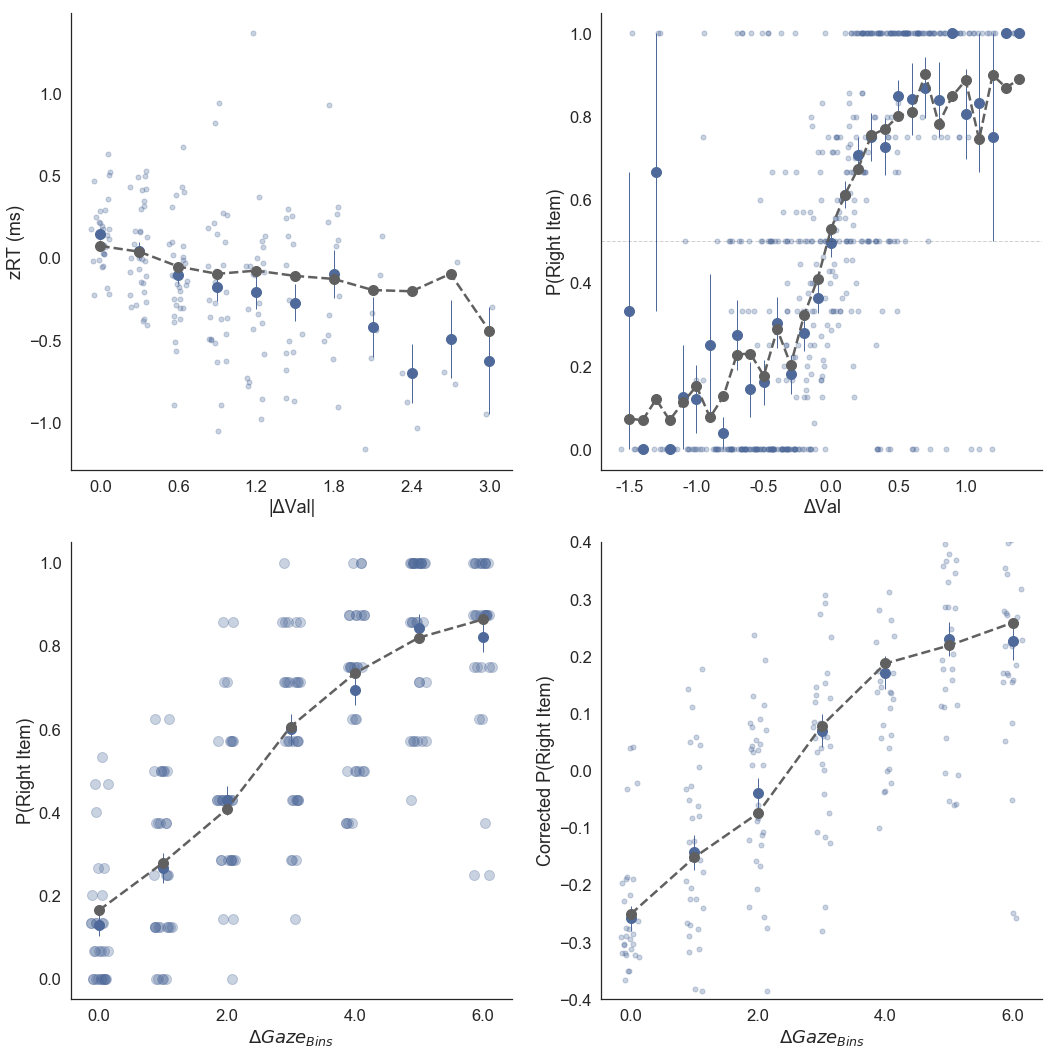

In [23]:
print('Close Figure to continue...')
glam.plot_fit(test_data, [glam_full.prediction]);
glam.plots_pretty.plot_fit(test_data, [glam_full.prediction]);

#glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);

plt.show()

## [END] 